# Analyzing Chipotle Data



---

For this exercise, I will complete a series of exercises exploring [order data from Chipotle](https://github.com/TheUpshot/chipotle), compliments of _The New York Times'_ "The Upshot."

Objective: To understand the essentials of Chipotle's order data: how many orders are being made, the average price per order, how many different ingredients are used, etc. This is a practice for business analysis skills.

---

## Basic Level

### Part 1: Read in the file with `csv.reader()` and store it in an object called `file_nested_list`.

Note: The data is in TSV (tab-separated value) file, and `csv.reader()` needs to be told [how to handle it](https://docs.python.org/2/library/csv.html).

In [990]:
import csv
import numpy as np
import pandas as pd
from collections import namedtuple   # Convenient to store the data rows

DATA_FILE = './data/chipotle.tsv'

In [935]:
with open(DATA_FILE) as file:
    reader = csv.reader(file, delimiter='\t')
    file_nested_list = [r for r in reader]

### Part 2: Separate `file_nested_list` into the `header` and the `data`.


In [936]:
headers = file_nested_list[0]
headers

['order_id', 'quantity', 'item_name', 'choice_description', 'item_price']

In [937]:
file_nested_list.pop(0)
file_nested_list[:5]

[['1', '1', 'Chips and Fresh Tomato Salsa', 'NULL', '$2.39 '],
 ['1', '1', 'Izze', '[Clementine]', '$3.39 '],
 ['1', '1', 'Nantucket Nectar', '[Apple]', '$3.39 '],
 ['1', '1', 'Chips and Tomatillo-Green Chili Salsa', 'NULL', '$2.39 '],
 ['2',
  '2',
  'Chicken Bowl',
  '[Tomatillo-Red Chili Salsa (Hot), [Black Beans, Rice, Cheese, Sour Cream]]',
  '$16.98 ']]

---

## Intermediate Level

### Part 3: Calculate the average price of an order.


In [979]:
#import csv into pd.df
chipotle = pd.read_csv(DATA_FILE, delimiter='\t',)
#do basic cleanup and set up of columns
chipotle['unit_price'] = pd.to_numeric(chipotle['item_price'].str.replace('$',''))
chipotle['item_price'] = chipotle['unit_price'] * chipotle['quantity']
chipotle = chipotle.reindex(columns=chipotle.columns[[0,1,2,3,5,4]])

In [980]:
#avg price per order
f"{chipotle.groupby('order_id')['item_price'].sum().mean():.2f}"

'21.39'

### Part 4: Create a list (or set) named `unique_sodas` containing all of unique sodas and soft drinks that Chipotle sells.

Note: Just look for `'Canned Soda'` and `'Canned Soft Drink'`, and ignore other drinks like `'Izze'`.

In [981]:
#more cleanup before using 'Canned' to get a boolean array, which is applied on choice_description, then get unique()
chipotle = chipotle.replace({'[Coca Cola]': '[Coke]'})
chipotle.choice_description[chipotle.item_name.str.contains('Canned')].unique()

array(['[Sprite]', '[Dr. Pepper]', '[Mountain Dew]', '[Diet Dr. Pepper]',
       '[Coke]', '[Diet Coke]', '[Lemonade]', '[Nestea]'], dtype=object)

---

## Advanced Level


### Part 5: Calculate the average number of toppings per burrito.

Note: Let's ignore the `quantity` column to simplify this task.




In [989]:
#get all toppings in pd.S
toppings = chipotle.choice_description[chipotle.item_name.str.contains('Burrito')].reset_index(drop=True)
#clean up and move toppings into pd.df
toppings = toppings.str.replace('[\[\]]','') 
toppings = toppings.str.split(',')
#get length, then mean
toppingsSalsa = toppings.apply(len)
f'{toppingsSalsa.mean():.2f}'

'5.40'

### Part 6: Create a dictionary. Let the keys represent chip orders and the values represent the total number of orders.

Expected output: `{'Chips and Roasted Chili-Corn Salsa': 18, ... }`


In [993]:
#allChipsOrdered is pd.S of all chips ordered
chipsOnlyBA = chipotle.item_name.str.contains('Chips')
allChipsOrdered = chipotle.item_name[chipsOnlyBA]

#clean dirty data for chips 
allChipsOrdered = allChipsOrdered.str.replace('-',' ')
allChipsOrdered = allChipsOrdered.str.replace('Chips and Mild Fresh Tomato Salsa','Chips and Fresh Tomato Salsa')
allChipsOrdered = allChipsOrdered.str.replace('Side of Chips','Chips')

#consider quantity ordered by using np.repeat to add to pd.S, then value_count orders.
allChipsOrdered = np.repeat(allChipsOrdered, chipotle.quantity[chipsOnlyBA])
countThemOrders = allChipsOrdered.value_counts()
countThemOrders

Chips and Guacamole                      506
Chips                                    340
Chips and Fresh Tomato Salsa             131
Chips and Tomatillo Green Chili Salsa     78
Chips and Tomatillo Red Chili Salsa       75
Chips and Roasted Chili Corn Salsa        41
Name: item_name, dtype: int64

In [994]:
chipsOrderDict = {}
for i in range(len(countThemOrders)):
    chipsOrderDict[countThemOrders.index[i]] = countThemOrders[i]
chipsOrderDict

{'Chips': 340,
 'Chips and Fresh Tomato Salsa': 131,
 'Chips and Guacamole': 506,
 'Chips and Roasted Chili Corn Salsa': 41,
 'Chips and Tomatillo Green Chili Salsa': 78,
 'Chips and Tomatillo Red Chili Salsa': 75}

### Try to find out something interesting:
What toppings typically are ordered with each other? Finding strong relationships allows ground staff to suggest or upsell additional toppings.

In [1051]:
### recommended topping pairings ###

#freshly gather all burrito toppings in a pd.S
toppings = chipotle.choice_description[chipotle.item_name.str.contains('Burrito')].reset_index(drop=True)
#clean up and move into a pd.df
toppings = toppings.str.replace('[\[\]]','')
toppings = toppings.str.split(', ', expand=True) #use ', ' with space to remove leading whitespace why do ppl do that
#clean dirty data
replacements = {
    'Salsa': None,  #remove #badData 'Salsa' as it doesn't provide any insights
    'Fajita Veggies':'Fajita Vegetables', #can't they use a drop down srsly
    'Vegetarian Black Beans':'Black Beans', #there must be a way to standardise
    'Rice':'Cilantro-Lime White Rice',
    'White Rice':'Cilantro-Lime White Rice',
    'Cilantro-Lime Rice':'Cilantro-Lime White Rice',
    'Brown Rice':'Cilantro-Lime Brown Rice',
    'Fresh Tomato Salsa':'Fresh Tomato Salsa (Mild)', #i mean..if DS are  spending 70% of their time...
    'Fresh Tomato (Mild)':'Fresh Tomato Salsa (Mild)', #people should be killed
    'Roasted Chili Corn Salsa':'Roasted Chili Corn Salsa (Medium)',
    'Roasted Chili Corn (Medium)':'Roasted Chili Corn Salsa (Medium)',
    'Tomatillo Green Chili Salsa':'Tomatillo-Green Chili Salsa (Medium)',
    'Tomatillo Green Chili (Medium)':'Tomatillo-Green Chili Salsa (Medium)',
    'Tomatillo Red Chili Salsa':'Tomatillo-Red Chili Salsa (Hot)', #is this DS life?
    'Tomatillo Red Chili (Hot)':'Tomatillo-Red Chili Salsa (Hot)' #i quit
}
toppings = toppings.replace(replacements)

#get pd.s of topping names
uniqueToppings = pd.Series(toppings.values.flatten()).sort_values().unique() 
uniqueToppings = pd.Series(uniqueToppings[uniqueToppings!=None])

#create pairing pd.df
pairTable = pd.DataFrame([], columns=uniqueToppings, index=uniqueToppings)

#loop it baby: per current topping, find how freq other toppings are bought with it, put in pairTable
for cTopping in uniqueToppings:
    #filter to display only cTopping in toppings, then count() per row
    isinOrder = toppings[toppings==cTopping].count(axis=1)
    #find out burrito orders containing cTopping: filter using boolean array
    ordersWithcTopping = toppings[isinOrder>=1]
    #toppings that are paired with cTopping. filter out cTopping, flatten, then value_count()
    toppingsPaired = ordersWithcTopping[ordersWithcTopping!=cTopping]
    pairCounts = pd.Series(toppingsPaired.values.flatten()).value_counts()
    #add it in baby
    pairTable[cTopping] = pairCounts

#eyeball if the logic tallies and prints True
checkTopping = 'Braised Barbacoa'
showOrders = toppings[toppings[toppings==checkTopping].count(axis=1)>=1]
showOrders.count().sum() - showOrders.index.size == pairTable[checkTopping].sum()

True

### Analysis
So we have a table of toppings most commonly ordered with each other. How do we begin?  
Recommend using largest int across all toppings or largest % per topping?  
What benchmark to cutoff: top 3 or top 25%?  
What base benchmark to ignore—do we need minimum int to start recommending?  
With current data set, I suggest largest %, cutoff at 75%, no base benchmark to include sufficient recommendations

### Findings
1) Presenting a table [recThese](http://localhost:8888/notebooks/unit-2_project-master/chipotle.ipynb#recThese) below that proposes toppings that goes with other toppings. Can be [filtered](http://localhost:8888/notebooks/unit-2_project-master/chipotle.ipynb#recThese-filter-by-toppings-cat) by topping category. To ask staff to suggest these with orders if any is missing, or upsell additional toppings.


### recThese

In [1054]:
#place recommended toppings in a pd.df
benchmark = pairTable.describe().loc['75%'] #toggle 25%, 50%, or 75%
recThese = pd.DataFrame([], index=uniqueToppings, columns=np.arange(8))
for cTopping in uniqueToppings:
    recThese.loc[cTopping] = pd.Series(pairTable[cTopping][pairTable[cTopping]>=benchmark[cTopping]].sort_values(ascending=False).index)
#insert toppings category for further analysis later
toppingsCat = ['mains','mains','grains','mains','extras','grains','grains','grains','Salsa - extras','extras','extras','grains','Salsa - extras','extras','Salsa - extras','Salsa - extras']
recThese.insert(0, 'cat', toppingsCat)
#format for easier viewing
recThese.fillna('-')

,cat,0,1,2,3,4,5,6,7
Adobo-Marinated and Grilled Chicken,mains,Sour Cream,Cilantro-Lime White Rice,Cheese,-,-,-,-,-
Adobo-Marinated and Grilled Steak,mains,Cilantro-Lime White Rice,-,-,-,-,-,-,-
Black Beans,grains,Cilantro-Lime White Rice,Cheese,Sour Cream,-,-,-,-,-
Braised Barbacoa,mains,Sour Cream,Cilantro-Lime White Rice,Cheese,-,-,-,-,-
Cheese,extras,Cilantro-Lime White Rice,Sour Cream,Lettuce,Fresh Tomato Salsa (Mild),-,-,-,-
Cilantro-Lime Brown Rice,grains,-,-,-,-,-,-,-,-
Cilantro-Lime White Rice,grains,Cheese,Sour Cream,Lettuce,Black Beans,-,-,-,-
Fajita Vegetables,grains,Cilantro-Lime White Rice,Cheese,Lettuce,-,-,-,-,-
Fresh Tomato Salsa (Mild),Salsa - extras,Cilantro-Lime White Rice,Cheese,Sour Cream,-,-,-,-,-
Guacamole,extras,Cilantro-Lime White Rice,Cheese,Sour Cream,Lettuce,-,-,-,-


### recThese filter by toppings category

In [1056]:
### recommended topping pairings filtered by category ###
whatCat = 'Salsa' #'mains' 'grains' 'extras' 'Salsa'
recThese[recThese.cat.str.contains(whatCat)].fillna('-') # 'mains' 'grains' 'extras' 'Salsa'

,cat,0,1,2,3,4,5,6,7
Fresh Tomato Salsa (Mild),Salsa - extras,Cilantro-Lime White Rice,Cheese,Sour Cream,-,-,-,-,-
Roasted Chili Corn Salsa (Medium),Salsa - extras,Cilantro-Lime White Rice,Cheese,Sour Cream,-,-,-,-,-
Tomatillo-Green Chili Salsa (Medium),Salsa - extras,Cilantro-Lime White Rice,Cheese,Sour Cream,-,-,-,-,-
Tomatillo-Red Chili Salsa (Hot),Salsa - extras,Cilantro-Lime White Rice,Cheese,Lettuce,-,-,-,-,-


### Findings
2) As seen above, Cilantro-Lime White Rice, Cheese and Sour Cream are highly commonly ordered. Even taking them out of consideration, the next set of recommended toppings are the same. Data is useful for catching missed toppings or upselling, but not recommendation for new topping pairings. Recommend to introduce and recommend other (seasonal) toppings.

### Visualising toppings ordered

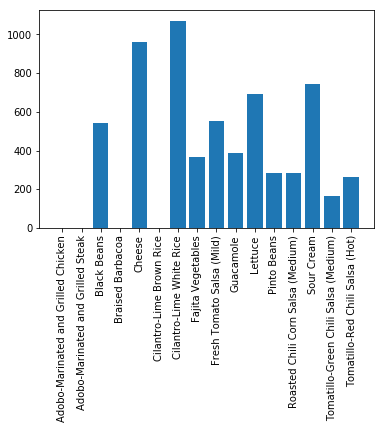

In [1048]:
import matplotlib.pyplot as plt
%matplotlib inline

countToppings = pd.Series(toppings.values.flatten()).value_counts()
plt.bar(countToppings.index,countToppings,)
plt.xticks(rotation=90)
plt.show()

### Findings
3) As seen above, Adobo-Marinated and Grilled Chicken, Adobo-Marinated and Grilled Steak, Braised Barbacoa, Cilantro-Lime Brown Rice shows [very few orders](http://localhost:8888/notebooks/unit-2_project-master/chipotle.ipynb#Visualising-toppings-ordered) compared to other toppings. If these are not newly introduced items, recommend to check data collection. If data integrity is intact, suggest to introduce alternatives (like mixed grain rice), promote poorly selling items, and/or source for better distributors for popular items.